<a href="https://colab.research.google.com/github/evanmacbride/microscope-autofocus/blob/main/notebooks/Walkthrough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initial setup
Set up the Colab notebook for the machine learning workflow.

In [104]:
# Import machine learning libraries
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import *
from xgboost import XGBRegressor as xgb
from sklearn.ensemble import RandomForestRegressor as randomforest
from sklearn.svm import NuSVR as svr
from sklearn.gaussian_process import GaussianProcessRegressor as gpr
from sklearn.neural_network import MLPRegressor as mlp
from sklearn.linear_model import RidgeCV

# Import image processing utility libraries
import cv2
import numpy as np
from scipy import ndimage

# Import file and visualization utility libraries
import concurrent.futures
from google.colab import drive
from google.colab.patches import cv2_imshow
from imutils import paths
import matplotlib.pyplot as plt
import re
import os
import zipfile

In [2]:
# Perform some additional preliminary setup

# Mount Google Drive
drive.mount('/content/drive')
# Random seed fix
random_seed = 42
tf.random.set_seed(random_seed)
np.random.seed(random_seed)
# Check TensorFlow version
print("TensorFlow Version:",tf.__version__)

Mounted at /content/drive
TensorFlow Version: 2.8.0


In [3]:
# Run nvidia-smi to ensure that our Colab session has a GPU. The output lists
# the GPU type and related information.
!nvidia-smi

Sat May  7 00:17:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Data Preprocessing
Perform edge detection by converting raw TIFF images to high pass filtered JPEGs. Set IMG_SRC_PATH equal to a directory of TIFF microscopy images.

In [4]:
IMG_SRC_PATH = '/content/drive/MyDrive/data/sample_data/level1/'
JPEG_PATH = IMG_SRC_PATH + 'jpeg/'

In [5]:
# Create a directory to save preprocessed images. Overwrite any existing
# directory of the same name.
!rm -rf $JPEG_PATH
!mkdir $JPEG_PATH

Source images found: 33
A sample raw image from the dataset:


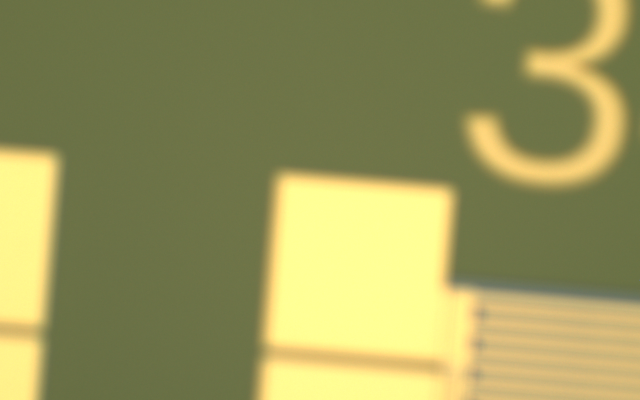

In [32]:
src_img_paths = list(paths.list_files(IMG_SRC_PATH, validExts="tiff"))
print("Source images found:",len(src_img_paths))

# Display a sample raw image

print("A raw image from the dataset:")
img = cv2.imread(src_img_paths[0])
img_rsz = cv2.resize(img, (640,400),interpolation=cv2.INTER_AREA)
cv2_imshow(img_rsz)

In [18]:
# Create JPEGs of high pass filtered images
kernel_size = 13
for img_path in src_img_paths:
    img = cv2.imread(img_path)
    # Apply the high pass filter
    hp_img = cv2.cvtColor(img - ndimage.gaussian_filter(img, kernel_size), 
                          cv2.COLOR_BGR2GRAY)
    src_bname = os.path.basename(img_path)
    src_fname, _ = os.path.splitext(src_bname)
    dest_fname = '{}{}.jpeg'.format(JPEG_PATH,src_fname)
    cv2.imwrite(dest_fname, hp_img)

A sample high pass filtered image (darker regions are flatter):


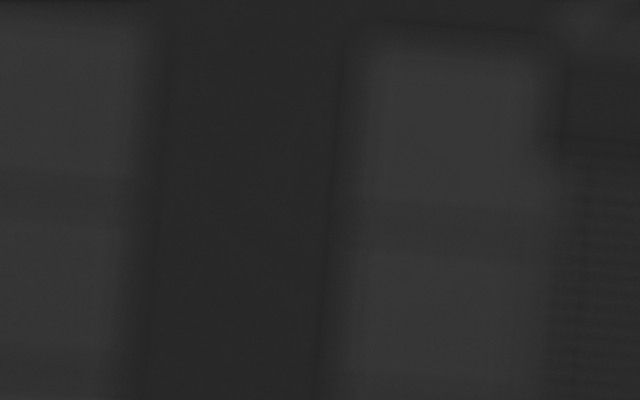

In [31]:
hp_img_rsz = cv2.resize(hp_img, (640,400),interpolation=cv2.INTER_AREA)
print("A high pass filtered image (darker regions are flatter):")
cv2_imshow(hp_img_rsz)

Apply a threshold to sort image stacks above or below a given percentage of edge pixels respectively as "clean" or "noisy." Put a cap on maximum absolute distance to the focal plane. Labels and X and Y coordinates are extracted from the file names of input data. Filenames must adhere to the naming standard: ```<TITLE>_ix<X_COORD>_iy<Y_COORD>_<DIST_TO_FOCAL_PLANE>.<FILE_EXT>.``` For example, ```adjustedFocus_tile__ix010_iy011_3.5722075563708766.jpeg``` fits the standard. The image in this file would be labeled with distance 3.5722075563708766. It would be marked at coordinates (10,11).

In [53]:
# Specify image dimensions
img_height=1200
img_width=1920

# Image preprocessing utility function
def parse_images(img_path,height=img_height,width=img_width):
  '''Given an image path, height, and width, return a resized float32 of the image.'''
  img_file = tf.io.read_file(img_path)
  img_jpeg = tf.io.decode_jpeg(img_file, channels=3)
  img_flt = tf.image.convert_image_dtype(img_jpeg, tf.float32)
  img_rsz = tf.image.resize(img_flt, size=[height, width])

  return img_rsz

In [20]:
###
### DEBUG ONLY
###

JPEG_PATH = '/content/drive/MyDrive/data/level1_jpeg/'

In [116]:
# Find the x and y coordinates of all images by parsing image filenames.

# Store image labels (i.e. distances to focal plane).
labels = []
# Store image positions. Each image stack will be at a set of X and Y 
# coordinates to be parsed from the filename.
all_coords = []

jpeg_img_paths = list(paths.list_files(JPEG_PATH, validExts="jpeg"))
for img_path in jpeg_img_paths:
  # Extract the image label from the filename
  img_bname = os.path.basename(img_path)
  img_fname, _ = os.path.splitext(img_bname)
  img_fname_split = re.split('_| ',img_fname)
  found_label = False
  tried_multiple = False
  for s in reversed(img_fname_split):
    try:
      label = np.abs(float(s))
      found_label = True
    except ValueError:
      print("Unable to parse filename {}. Tried to read {} as label.".format(img_bname,s))
      tried_multiple = True
      continue
    if found_label and tried_multiple:
      print("Found label:",s)
      break
    if found_label:
      break
  labels.append(label)
  # Extract the image coordinates from the filename
  coords = [c for c in img_path.split("_") if "ix" in c or "iy" in c]
  coor = "_".join(coords)
  all_coords.append(coor)
labels = np.array(labels)
all_coords = np.array(all_coords)

Unable to parse filename adjustedFocus_tile__ix005_iy015_-15.166218758450722 (1).jpeg. Tried to read (1) as label.
Found label: -15.166218758450722
Unable to parse filename adjustedFocus_tile__ix005_iy015_-33.745665290158854 (1).jpeg. Tried to read (1) as label.
Found label: -33.745665290158854
Unable to parse filename adjustedFocus_tile__ix005_iy015_-38.518800564087485 (1).jpeg. Tried to read (1) as label.
Found label: -38.518800564087485
Unable to parse filename adjustedFocus_tile__ix014_iy000_-10.271774026431647 (1).jpeg. Tried to read (1) as label.
Found label: -10.271774026431647
Unable to parse filename adjustedFocus_tile__ix014_iy000_-11.532291924414794 (1).jpeg. Tried to read (1) as label.
Found label: -11.532291924414794
Unable to parse filename adjustedFocus_tile__ix014_iy000_-34.79015755973316 (1).jpeg. Tried to read (1) as label.
Found label: -34.79015755973316
Unable to parse filename adjustedFocus_tile__ix014_iy000_-4.195619281228035 (1).jpeg. Tried to read (1) as label.


In [86]:
# Save images as clean or discard as noisy. Evaluate the in-focus image in each
# image stack to determine if it's "clean" data or noise. If the in-focus image
# in a stack is clean, then the entire stack is clean.

# The filtered image pixel intensity required to consider a pixel to belong to
# an edge
intensity_thresh = 0.50
# Edge area percentage threshold (EAPT). The percentage of image edge pixels 
# required to consider the image "clean"
eap_thresh = 0.10

# In-focus image path positions in the list of image paths
infocus_img_pos = np.where(labels==0)[0]
# X/Y coordinate strings of physical locations of in-focus images
infocus_coords = all_coords[infocus_img_pos]
# Filenames for in-focus images
img_select = np.array(jpeg_img_paths)[infocus_img_pos]
edge_percentages = []
# Store X and Y coordinates of "clean" image stacks
clean_infocus_coords = []
#for img_path in img_select:
for img_path, pos in zip(img_select, infocus_coords):
  img_pixel_vals = parse_images(img_path)[:,:,0]
  pixels_above_threshold = len(np.where(img_pixel_vals >= 
                                        intensity_thresh)[0])
  edge_percentage = pixels_above_threshold / img_height / img_width
  edge_percentages.append(edge_percentage)
  if edge_percentage >= eap_thresh:
    clean_infocus_coords.append(pos)

In [73]:
# After finding which in-focus images are clean, find the other images in the
# clean image stacks and save them as clean as well.

clean_stack_pos_list = []
for cs in clean_infocus_coords:
  clean_position = np.where(all_coords==cs)[0]
  for pos in clean_position:
    clean_stack_pos_list.append(pos)

jpeg_imgs_select = np.array(jpeg_img_paths)
clean_paths = jpeg_imgs_select[clean_stack_pos_list]

A clean, in-focus image.
Filename: /content/drive/MyDrive/data/level1_jpeg/adjustedFocus_tile__ix005_iy001_0.jpeg


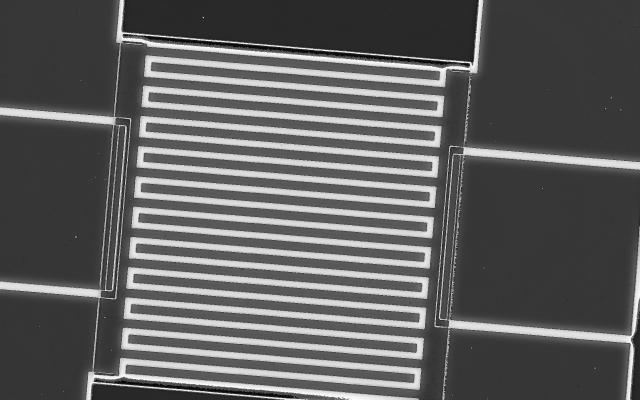

In [102]:
# Display an example clean, in-focus image
clean_example = clean_paths[5]
img = cv2.imread(clean_example)
img_rsz = cv2.resize(img, (640,400),interpolation=cv2.INTER_AREA)
print("A clean, in-focus image.")
print("Filename:",clean_example)
cv2_imshow(img_rsz)

In [74]:
# Now put a cap on the maximum allowable distance to the focal plane. Reject
# images that are at a distance above this cap.

# The cap on an image's allowable maximum absolute distance to the focal plane
cap = 20

clean_labels = labels[clean_stack_pos_list]

# not include the focal distance larger than cap
capped_clean_labels = clean_labels[np.where(np.abs(clean_labels)<=cap)[0]]
capped_clean_paths = clean_paths[np.where(np.abs(clean_labels)<=cap)[0]]

print("Number of clean images below the focal distance cap:",len(capped_clean_labels))

Number of clean images below the focal distance cap: 141


## Initiate our cnn model

In [ ]:
Resnet50_transfer = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights="imagenet",
    # weights=None,
    input_tensor=None,
    input_shape=(img_height, img_width, 3), 
    pooling=None,
)

Resnet50_transfer.trainable = True

94781440/94765736 [==============================] - 2s 0us/step


In [ ]:
Resnet50_transfer.trainable = False

supervise_model = tf.keras.models.Sequential([
    
    Resnet50_transfer,
    GlobalAveragePooling2D(),
    # BatchNormalization(epsilon=0.1),
    # Dense(64, activation='relu'),
    # Dropout(0.5),
    # BatchNormalization(epsilon=0.1),
    # Dense(32, activation='relu'),
    # Dropout(0.5),
    # BatchNormalization(epsilon=0.1),
    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(1)
])

In [ ]:
# adam = tf.keras.optimizers.Adam(learning_rate=0.001)
# sgd = tf.keras.optimizers.SGD(learning_rate=0.001)
# metrics = ['mae'
#                 ]
# supervise_model.compile(loss = 'mse', optimizer = adam, metrics = metrics)
# supervise_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 38, 60, 2048)      23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 16)                32784     
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 23,620,513
Trainable params: 32,801
Non-trainable params: 23,587,712
_______________________________________

In [ ]:
# Redefine parse_images with TensorFlow's @tf.function decorator.
@tf.function
def parse_images(img_path,height=img_height,width=img_width):
  '''Given an image path, height, and width, return a resized float32 of the image.'''
  img_file = tf.io.read_file(img_path)
  img_jpeg = tf.io.decode_jpeg(img_file, channels=3)
  img_flt = tf.image.convert_image_dtype(img_jpeg, tf.float32)
  img_rsz = tf.image.resize(img_flt, size=[height, width])

  return img_rsz

In [ ]:
# cnn feature extraction in segments so as to avoid OOM problem, that we encountered with image set size larger than 1000.
feature_extractor = Model(supervise_model.input, supervise_model.layers[-4].output)
n_segments = len(capped_clean_paths) // 500 + 1
training_batch_size = 1

for i in range(n_segments):
  if i == 0:
    train_ds = tf.data.Dataset.from_tensor_slices(capped_clean_paths[:(i + 1) * 500])
    train_ds = (
        train_ds
        .map(parse_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        .batch(training_batch_size
              #  , drop_remainder=True
              )
        .prefetch(tf.data.experimental.AUTOTUNE)
    )

    features = feature_extractor.predict(train_ds)

  else:
    train_ds = tf.data.Dataset.from_tensor_slices(capped_clean_paths[i * 500 :(i + 1) * 500])
    train_ds = (
        train_ds
        .map(parse_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        .batch(training_batch_size
              #  , drop_remainder=True
              )
        .prefetch(tf.data.experimental.AUTOTUNE)
    )

    features = np.append(features, feature_extractor.predict(train_ds), axis=0)

## KFolds validation

In [ ]:
training_data_size = np.array([10, 20, 50, 80, 100, 150, 200])
n_folds = 5
n_split_split = 20
n_validation_images = 50
rkf = RepeatedKFold(n_splits=n_folds, n_repeats=n_split_split, random_state=42)

xgb_scores = np.zeros((len(training_data_size), n_folds * n_split_split, 2))
ridge_scores = np.zeros((len(training_data_size), n_folds * n_split_split, 2))
rf_scores = np.zeros((len(training_data_size), n_folds * n_split_split, 2))
sv_scores = np.zeros((len(training_data_size), n_folds * n_split_split, 2))
gp_scores = np.zeros((len(training_data_size), n_folds * n_split_split, 2))
mlp_scores = np.zeros((len(training_data_size), n_folds * n_split_split, 2))

k = 0
for train_ix, test_ix in rkf.split(features, capped_clean_labels):
  
      Train_feature, val_feature = features[train_ix], features[test_ix]
      Train_label, val_label = capped_clean_labels[train_ix], capped_clean_labels[test_ix]
      val_feature = val_feature[:n_validation_images]
      val_label = val_label[:n_validation_images]
      
      for i in range(len(training_data_size)):

        # initate regressors
        xg_boost_regressor = xgb(max_depth=16, learning_rate=0.1, tree_method='gpu_hist', objective='reg:squarederror')         # don't go beyond max_depth of 16, session will crash due to OOM
        ridge_regressor = RidgeCV()
        rf_regressor = randomforest(max_depth=16)
        sv_regressor = svr()
        gp_regressor = gpr()
        mlp_regressor = mlp(hidden_layer_sizes=(100, 100, 100), max_iter=1000)

        train_feature = Train_feature[:training_data_size[i]]
        train_label = Train_label[:training_data_size[i]]

        ## add or comment out regressors here


        xg_boost_regressor.fit(train_feature, train_label)
        y_pred_xgb = xg_boost_regressor.predict(val_feature)
        xgb_scores[i, k, 0] = r2_score(y_pred_xgb, val_label)
        xgb_scores[i, k, 1] = mean_absolute_error(y_pred_xgb, val_label)

        ridge_regressor.fit(train_feature, train_label)
        y_pred_ridge = ridge_regressor.predict(val_feature)
        ridge_scores[i, k, 0] = r2_score(y_pred_ridge, val_label)
        ridge_scores[i, k, 1] = mean_absolute_error(y_pred_ridge, val_label)

        rf_regressor.fit(train_feature, train_label)
        y_pred_rf = rf_regressor.predict(val_feature)
        rf_scores[i, k, 0] = r2_score(y_pred_rf, val_label)
        rf_scores[i, k, 1] = mean_absolute_error(y_pred_rf, val_label)

        sv_regressor.fit(train_feature, train_label)
        y_pred_sv = sv_regressor.predict(val_feature)
        sv_scores[i, k, 0] = r2_score(y_pred_sv, val_label)
        sv_scores[i, k, 1] = mean_absolute_error(y_pred_sv, val_label)

        gp_regressor.fit(train_feature, train_label)
        y_pred_gp = gp_regressor.predict(val_feature)
        gp_scores[i, k, 0] = r2_score(y_pred_gp, val_label)
        gp_scores[i, k, 1] = mean_absolute_error(y_pred_gp, val_label)

        mlp_regressor.fit(train_feature, train_label)
        y_pred_mlp = mlp_regressor.predict(val_feature)
        mlp_scores[i, k, 0] = r2_score(y_pred_mlp, val_label)
        mlp_scores[i, k, 1] = mean_absolute_error(y_pred_mlp, val_label)
        
      k += 1

np.savez_compressed('performance_log/level1/cap%i_cutoff%1.2f_clean%i.npz' %(cap, eap_thresh, len(capped_clean_labels)), xgb=xgb_scores, ridge=ridge_scores, rf=rf_scores, sv=sv_scores, gp=gp_scores, mlp=mlp_scores)

In [ ]:
for i in range(len(training_data_size)):
  print('training_data_size: %i' % training_data_size[i])
  print(np.average(xgb_scores[i, :, 0]))
  print(np.std(xgb_scores[i, :, 0]))
  print(np.average(xgb_scores[i, :, 1]))
  print(np.std(xgb_scores[i, :, 1]))
  print(np.average(ridge_scores[i, :, 0]))
  print(np.std(ridge_scores[i, :, 0]))
  print(np.average(ridge_scores[i, :, 1]))
  print(np.std(ridge_scores[i, :, 1]))
  print(np.average(rf_scores[i, :, 0]))
  print(np.std(rf_scores[i, :, 0]))
  print(np.average(rf_scores[i, :, 1]))
  print(np.std(rf_scores[i, :, 1]))
  print(np.average(sv_scores[i, :, 0]))
  print(np.std(sv_scores[i, :, 0]))
  print(np.average(sv_scores[i, :, 1]))
  print(np.std(sv_scores[i, :, 1]))
  print(np.average(gp_scores[i, :, 0]))
  print(np.std(gp_scores[i, :, 0]))
  print(np.average(gp_scores[i, :, 1]))
  print(np.std(gp_scores[i, :, 1]))
  print(np.average(mlp_scores[i, :, 0]))
  print(np.std(mlp_scores[i, :, 0]))
  print(np.average(mlp_scores[i, :, 1]))
  print(np.std(mlp_scores[i, :, 1]))

training_data_size: 10
0.14084248695740414
2.7596362558658334
3.072736385648594
0.8956592728706928
-0.7766834675071752
7.595225687628904
2.919382927749211
0.8930499778813756
-4.75159455046763
21.32244198472842
3.707794289579082
0.8381547926925947
-1376046.7630098618
2118775.2312446465
6.652055530528884
0.7328939987957965
-20.139719237492674
114.14783619964996
4.195719456627305
1.0904307439505168
0.31790680908968794
2.390246555151645
2.4593776514136305
1.134806561531438
training_data_size: 20
0.6127460916004517
0.14273374618180942
2.5826030791908217
0.4023774093347564
0.5979328567114998
0.12393640668622741
2.727254395662266
0.3551364679070613
0.4695063402054142
0.20017859336515761
2.688883169837599
0.38192943109347943
-119141.3728962809
93425.85060880502
6.27230394648212
0.6147711495190518
0.4227523017135294
0.2049816135261394
3.532484646850965
0.4839886312193726
0.7459562784933172
0.12870139680243298
2.076345256859041
0.4731978555179052
training_data_size: 50
0.8203983095044499
0.08137

In [ ]:
# rf_regressor = randomforest(max_depth=16)
features_train, features_test, train_label, test_label = train_test_split(features, capped_clean_labels, test_size=0.2, random_state=42)
# rf_regressor.fit(features_train, train_label)
y_pred_rf = rf_regressor.predict(features_test)

rf prediction r2_score = 0.984096
rf prediction mean_absolute_error = 0.531279


Text(0, 0.5, 'predicted_distance [$\\mu m$]')

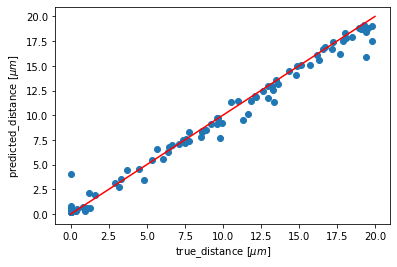

In [ ]:
print('rf prediction r2_score = %f' % r2_score(y_pred_rf, test_label))
print('rf prediction mean_absolute_error = %f' % mean_absolute_error(y_pred_rf, test_label))
plt.scatter(test_label, y_pred_rf)
plt.plot(np.linspace(0, cap, 150), np.linspace(0, cap, 150), c='r')
plt.xlabel('true_distance [$\mu m$]')
plt.ylabel('predicted_distance [$\mu m$]')

In [ ]:
ridge_regressor.fit(extracted_features_train, train_label)
y_pred_ridge = ridge_regressor.predict(extracted_features_test)

RidgeCV prediction r2_score = 0.688922
RidgeCV prediction mean_absolute_error = 2.739158


Text(0, 0.5, 'predicted_distance')

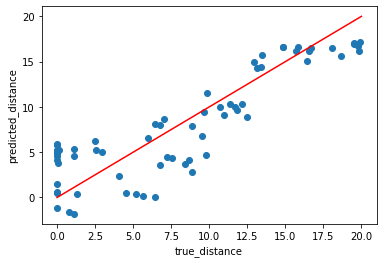

In [ ]:
print('RidgeCV prediction r2_score = %f' % r2_score(y_pred_ridge, test_label))
print('RidgeCV prediction mean_absolute_error = %f' % mean_absolute_error(y_pred_ridge, test_label))
plt.scatter(test_label, y_pred_ridge)
plt.plot(np.linspace(0, cap, 150), np.linspace(0, cap, 150), c='r')
plt.xlabel('true_distance')
plt.ylabel('predicted_distance')

In [ ]:
tf.random.set_seed(42)
supervise_history = supervise_model.fit(train_ds,
                 validation_data=test_ds,                      
                 batch_size=training_batch_size,                       
                 epochs=10,                                           
                 workers=8,                                            
                 use_multiprocessing=True,                             
                 verbose=1)                                         
                #  callbacks=[MetricsCheckpoint('small_supervise')])  

Epoch 1/10
21/21 [==============================] - 55s 2s/step - loss: 30.6404 - mae: 4.4466 - val_loss: 25.7785 - val_mae: 4.5040
Epoch 2/10
21/21 [==============================] - ETA: 0s - loss: 27.6751 - mae: 4.4045

InvalidArgumentError: ignored